In [232]:
import tiktoken
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from os import path
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

In [233]:
def read_data(filepath):
    with open(filepath, 'r', encoding='utf-8') as file:
        return file.read()

books = [
    "tinyshakespear", "book-war-and-peace", "Frankenstein",
    "moby_dick", "pride_and_prejudice", "taylor_swift", "wonderland"
]

all_texts = []
for book in books:
    filepath = path.join("../data", book + ".txt")
    all_texts.append(read_data(filepath))

data = "".join(all_texts)

print(f"Total length: {len(data)} characters.")

Total length: 8185009 characters.


In [234]:
enc = tiktoken.get_encoding("r50k_base")
vocab_size = enc.n_vocab

with open("vocab_dump.txt", "w", encoding="utf-8") as f:
    decoded = enc.decode([i for i in range(vocab_size)])
    f.write(decoded)
print(vocab_size)

50257


In [235]:
encoded_data = np.array(list(enc.encode(data)))

split_index = int(len(encoded_data) * 0.9)
train_data = encoded_data[:split_index]
test_data = encoded_data[split_index:]

print(f"Total data length: {len(encoded_data)}")
print(f"Split index: {split_index}")
print(f"Train data length: {len(train_data)}")
print(f"Test data length: {len(test_data)}")
print(f"Sum of train and test lengths: {len(train_data) + len(test_data)}")

Total data length: 2191900
Split index: 1972710
Train data length: 1972710
Test data length: 219190
Sum of train and test lengths: 2191900


In [236]:
d_model = 384
n_heads = 12
d_head = 32 # changeables

vocab_size = enc.n_vocab
batch_size = 32
context_len = 128
lr = 3e-4
epochs = 40_000
eval_iters = 20
device = 'mps'

load_check_point = True

In [237]:
def get_batch(split):
    data_ = train_data if split == 'train' else test_data
    ix = torch.randint(len(data_) - context_len, (batch_size, ))
    x = torch.stack([torch.from_numpy((data_[i:i+context_len]).astype(np.int64)) for i in ix])
    y = torch.stack([torch.from_numpy((data_[i+1:i+1+context_len]).astype(np.int64)) for i in ix])
    return x, y

In [238]:
class OneLayerTransformer(nn.Module):
    def __init__(self, vocab_size: int, d_model: int, n_heads: int, d_head: int, context_len: int):
        super().__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.n_heads = n_heads
        self.d_head = d_head 
        self.context_len = context_len
        # Embedding
        self.W_E = nn.Embedding(self.vocab_size, self.d_model)
        self.W_pos = nn.Embedding(context_len, d_model)
        self.W_Q = nn.Linear(self.d_model, self.n_heads * self.d_head, bias=False)
        self.W_K = nn.Linear(self.d_model, self.n_heads * self.d_head, bias=False)
        self.W_V = nn.Linear(self.d_model, self.n_heads * self.d_head, bias=False)
        self.W_O = nn.Linear(self.n_heads * self.d_head, self.d_model, bias=False)
        # Unembedding
        self.W_U = nn.Linear(self.d_model, self.vocab_size)

    def forward(self, x: torch.Tensor, return_all: bool = False) -> torch.Tensor:
        device = x.device
        d_head, n_heads = self.d_head, self.n_heads
        B, T = x.shape
        pos = torch.arange(T, device=device)
        x = self.W_E(x) + self.W_pos(pos)
        
        residual = x 
        # B, T, C
        q = self.W_Q(x) # (B, T, n_heads * d_head)
        k = self.W_K(x) # 
        v = self.W_V(x)

        # To parallelize acros heads and batches
        q = q.view(B, T, n_heads, d_head).transpose(1, 2)
        v = v.view(B, T, n_heads, d_head).transpose(1, 2)
        k = k.view(B, T, n_heads, d_head).transpose(1, 2)
                                # B, T, n_heads, d_head -> B, T, n_heads, d_head
        scores = torch.matmul(q, k.transpose(-2, -1)) / d_head ** 0.5 # [B, n_heads, T, d_head] @ [B, n_heads, d_head, T] = B, n_heads, T, T
        mask = torch.triu(torch.ones(T, T, device=device, dtype=torch.bool), diagonal=1)
        scores = scores.masked_fill(mask, float('-inf'))
        # 4. Softmax
        pattern = F.softmax(scores, dim=-1)

        z = torch.matmul(pattern, v) # [B, n_heads, T, d_head]
        z = z.transpose(1, 2).contiguous().view(B, T, -1)
        attn_out = self.W_O(z)

        hidden_state = attn_out + residual
        logits = self.W_U(hidden_state)
        if return_all:
            return logits, scores, pattern, v, z, hidden_state
        return logits 


In [239]:
model = OneLayerTransformer(
    vocab_size=vocab_size,
    d_model= d_model,
    n_heads=n_heads,
    d_head=d_head,
    context_len=context_len
)

if load_check_point:
    model.load_state_dict(torch.load('one_layer_transformer.pth'))

optim = optim.AdamW(model.parameters(), lr)
model.to(device)

OneLayerTransformer(
  (W_E): Embedding(50257, 384)
  (W_pos): Embedding(128, 384)
  (W_Q): Linear(in_features=384, out_features=384, bias=False)
  (W_K): Linear(in_features=384, out_features=384, bias=False)
  (W_V): Linear(in_features=384, out_features=384, bias=False)
  (W_O): Linear(in_features=384, out_features=384, bias=False)
  (W_U): Linear(in_features=384, out_features=50257, bias=True)
)

In [240]:
for epoch in range(1000):
    model.train()
    
    xb, yb = get_batch('train')
    xb, yb = xb.to(device), yb.to(device)

    # Forward pass
    logits = model(xb)
    B, T, C = logits.shape
    loss = F.cross_entropy(logits.view(B*T, C), yb.view(B*T))

    # Backward pass
    optim.zero_grad()
    loss.backward()
    optim.step()

    if epoch % 100 == 0:
        print(f"====== Loss {epoch}: {loss.item()}")

====== Loss 0: 2.2717034816741943
====== Loss 100: 2.451565742492676
====== Loss 200: 2.3435120582580566
====== Loss 300: 2.588682174682617
====== Loss 400: 2.4761946201324463
====== Loss 500: 2.4061079025268555
====== Loss 600: 2.327664375305176
====== Loss 700: 2.392660617828369
====== Loss 800: 2.319274425506592
====== Loss 900: 2.2660512924194336


In [241]:
torch.save(model.state_dict(),'one_layer_transformer.pth')

In [242]:
from torch.nn.functional import cosine_similarity
embedding_weights = model.W_E.weight

def find_closest_words(word, top_n=50):
    word_id = enc.encode(word)
    word_vector = embedding_weights[word_id]
    
    similarities = cosine_similarity(word_vector.unsqueeze(0), embedding_weights)
    
    top_values, top_indices = similarities.topk(top_n + 1)
    
    print(f"\nWords most similar to '{word}':")
    for i in range(1, top_n + 1): # Start at 1 to skip the word itself
        similar_word_id = top_indices[0][i].item()
        print(similar_word_id)
        similar_word = enc.decode([similar_word_id])
        similarity_score = top_values[0][i].item()
        print(f"   - {similar_word}: {similarity_score:.4f}")

find_closest_words("cat", top_n=5)
find_closest_words("love", top_n=5)


Words most similar to 'cat':
36
   - E: 0.0356
44
   - M: 0.0336
164
   - �: 0.0306
226
   - �: 0.0282
302
   -  re: 0.0273

Words most similar to 'love':
218
   - : 0.0385
36
   - E: 0.0356
187
   - �: 0.0348
44
   - M: 0.0336
117
   - �: 0.0300


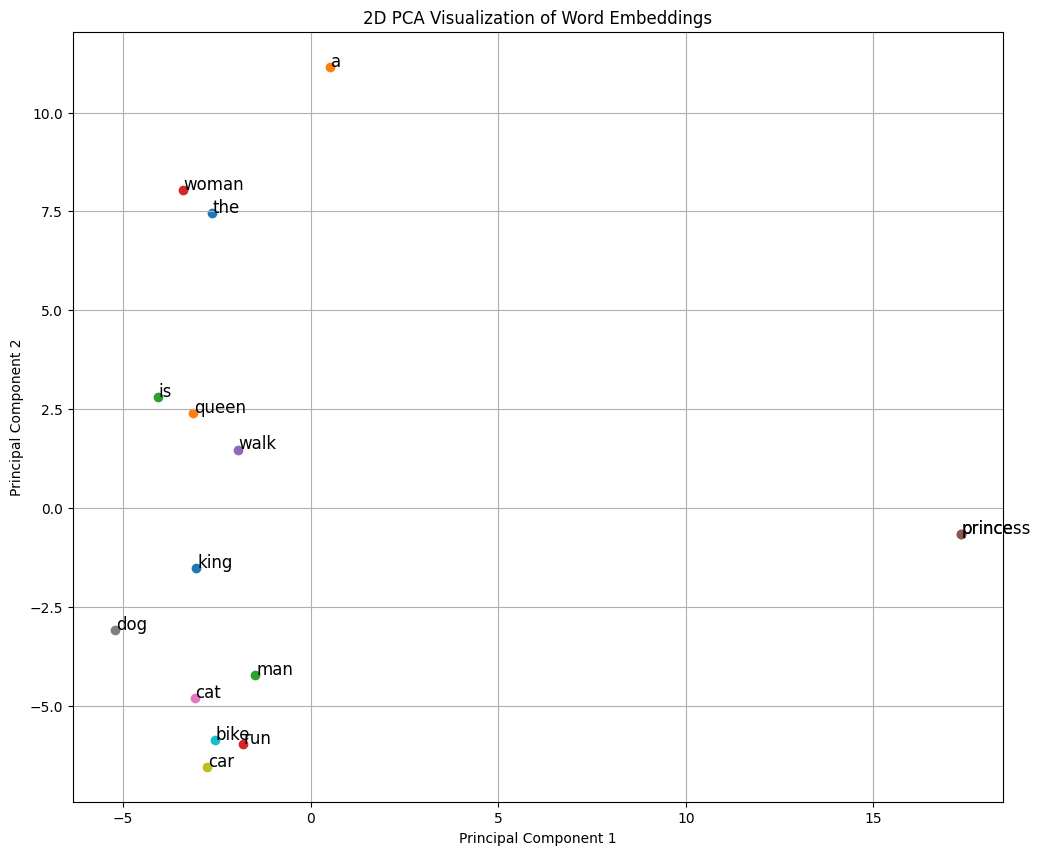

In [243]:
embeddings = model.W_E.weight.detach().cpu().numpy()
vocab_size, d_model = embeddings.shape

all_tokens = [enc.decode([i]) for i in range(vocab_size)]

words_to_track = ["king", "queen", "man", "woman", "prince", "princess", 
                  "cat", "dog", "car", "bike", "the", "a", "is", "run", "walk"]

indices_to_track = [enc.encode(word)[0] for word in words_to_track]

embeddings_subset = embeddings[indices_to_track]

pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings_subset)

plt.figure(figsize=(12, 10))

for i, word in enumerate(words_to_track):
    x, y = embeddings_2d[i, 0], embeddings_2d[i, 1]
    plt.scatter(x, y)
    plt.text(x + 0.02, y + 0.02, word, fontsize=12)

plt.title("2D PCA Visualization of Word Embeddings")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()


In [244]:
vs = torch.tensor([i for i in range(vocab_size)])
print(f"Original shape: {vs.shape}") # torch.Size([vocab_size])

vs_reshaped = vs.unsqueeze(1) 

print(f"Reshaped tensor shape: {vs_reshaped.shape}") # torch.Size([vocab_size, 1])


model.eval()
model.to('cpu') 

with torch.no_grad(): # Use no_grad for inference to save memory and computation
    logits_ = model(vs_reshaped)

print(f"Final logits shape: {logits_.shape}")

Original shape: torch.Size([50257])
Reshaped tensor shape: torch.Size([50257, 1])
Final logits shape: torch.Size([50257, 1, 50257])


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5, 20.5, 21.5,
        22.5, 23.5, 24.5, 25.5, 26.5, 27.5, 28.5, 29.5, 30.5, 31.5, 32.5,
        33.5, 34.5, 35.5, 36.5, 37.5, 38.5, 39.5, 40.5, 41.5, 42.5, 43.5,
        44.5, 45.5, 46.5, 47.5, 48.5, 49.5, 50.5, 51.5, 52.5, 53.5, 54.5,
        55.5, 56.5, 57.5, 58.5, 59.5, 60.5, 61.5, 62.5, 63.5, 64.5, 65.5,
        66.5, 67.5, 68.5, 69.5, 70.5, 71.5, 72.5, 73.5, 74.5, 75.5, 76.5,
        77.5, 78.5, 79.5, 80.5, 81.5, 82.5, 83.5, 84.5, 85.5, 86.5, 87.5,
        88.5, 89.5, 90.5, 91.5, 92.5, 93.5, 94.5, 95.5, 96.5, 97.5, 98.5,
        99.5]),
 [Text(0, 0.5, 'th'),
  Text(0, 1.5, ' com'),
  Text(0, 2.5, ' G'),
  Text(0, 3.5, 'un'),
  Text(0, 4.5, 'op'),
  Text(0, 5.5, '00'),
  Text(0, 6.5, ' L'),
  Text(0, 7.5, ' not'),
  Text(0, 8.5, 'ess'),
  Text(0, 9.5, ' ex'),
  Text(0, 10.5, ' v'),
  Text(0, 11.5, 'res'),
  Text(0, 12.5, ' E'),
  Text(0, 13.5, 'ew'),

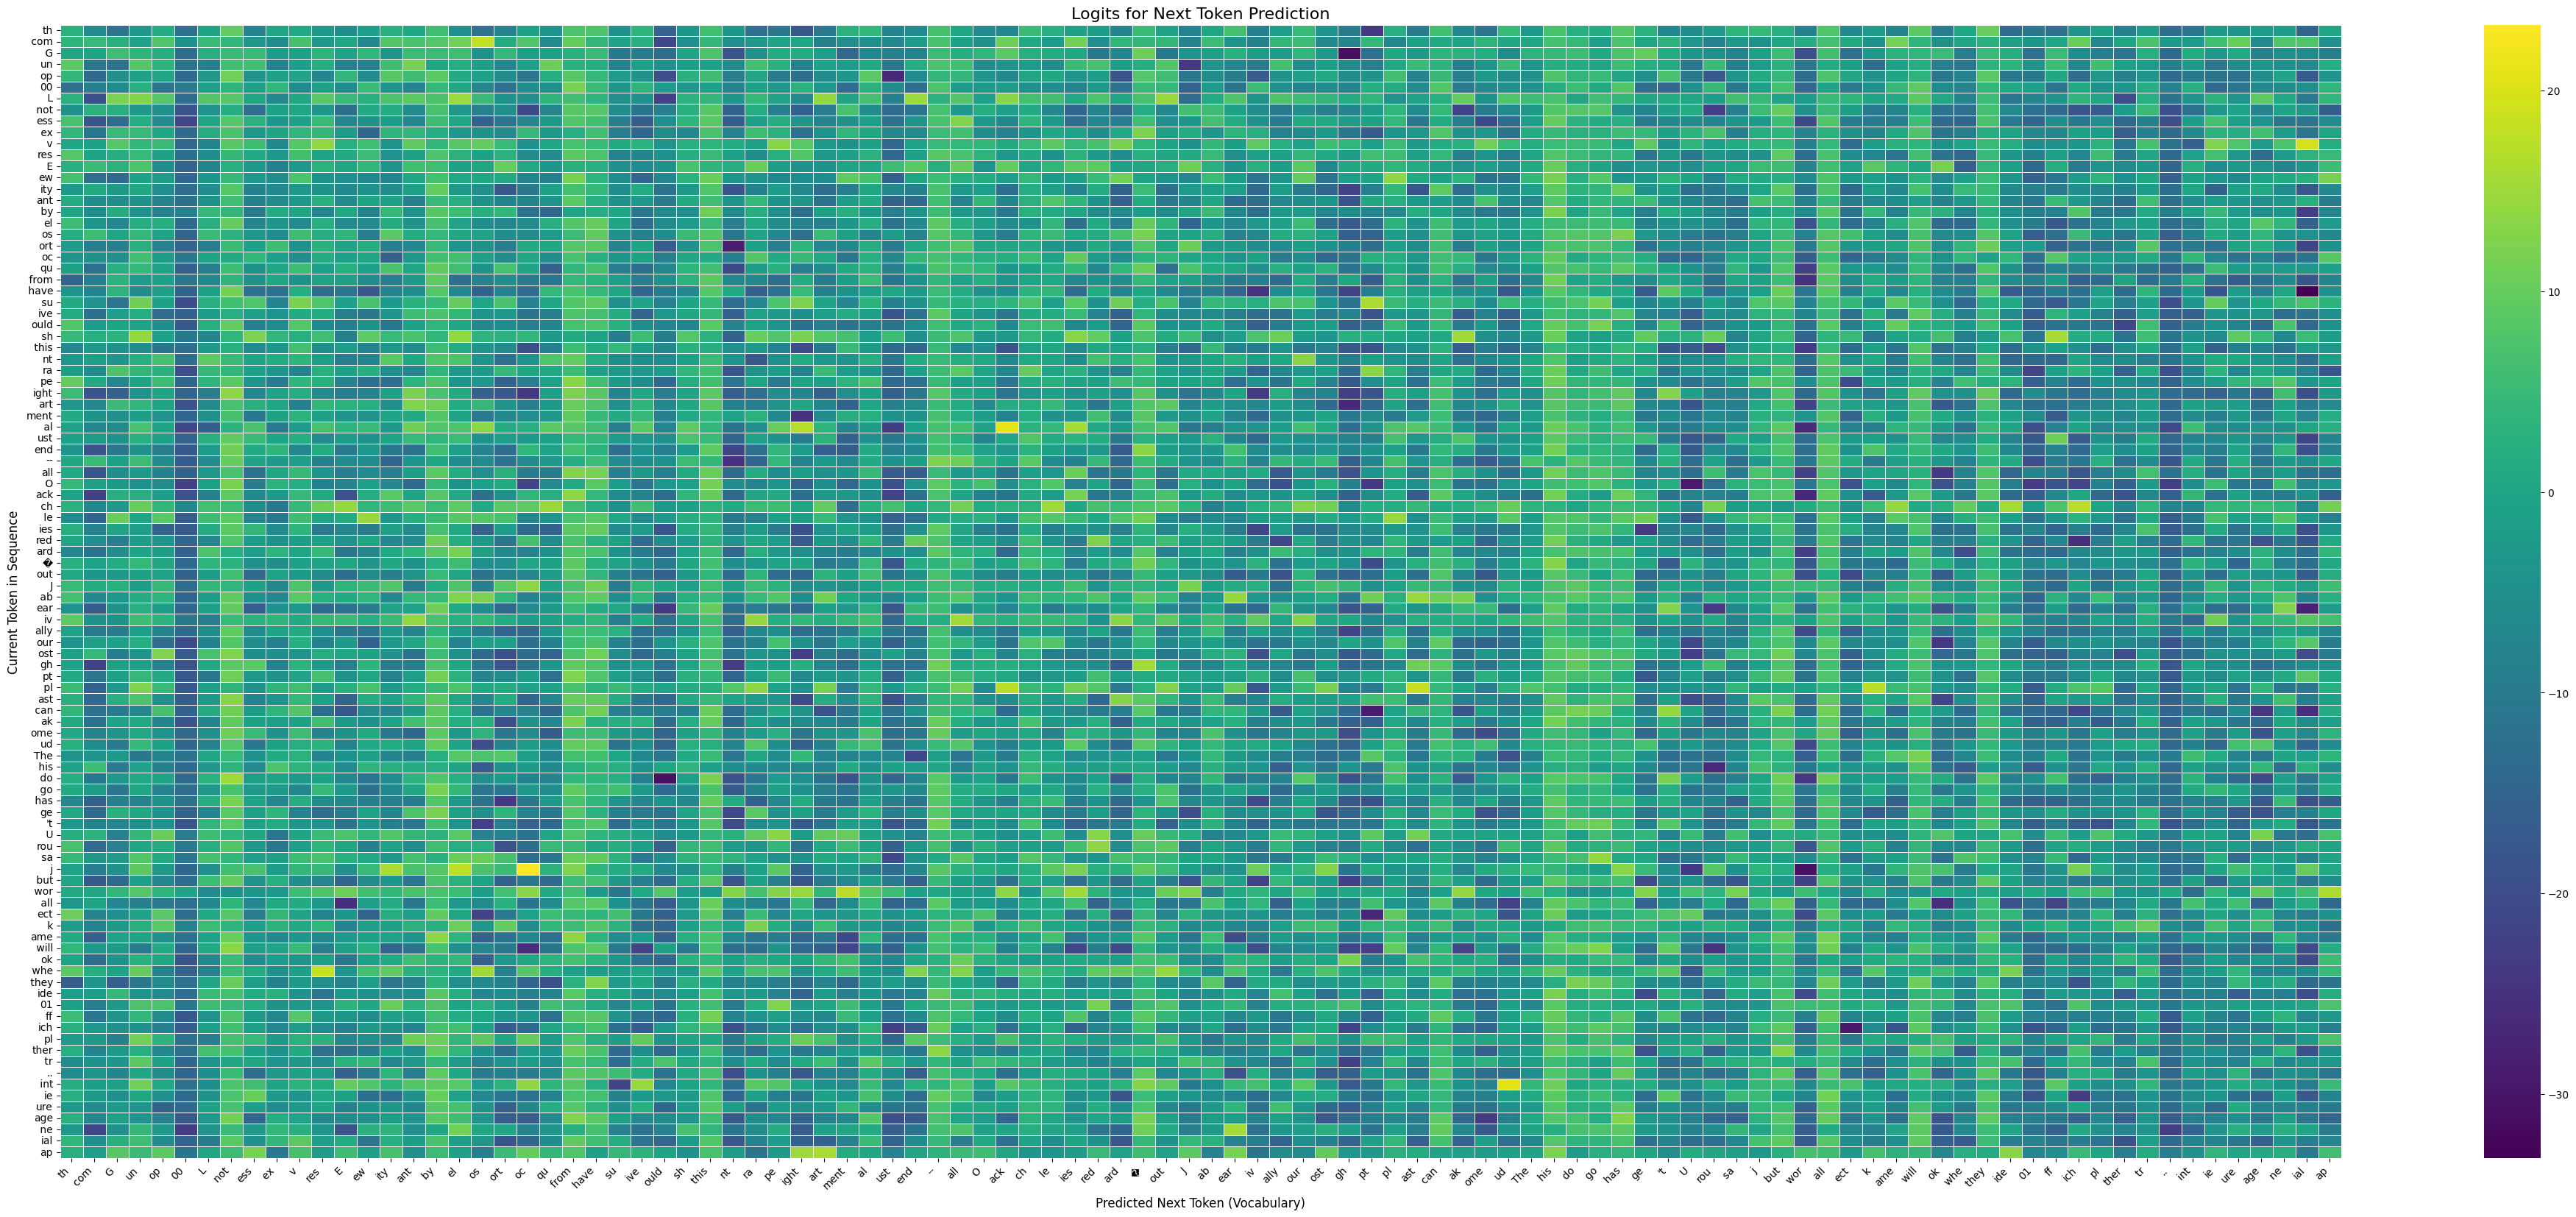

In [245]:
logits_ = logits_.reshape(50257, 50257)
logits_data = logits_.detach().numpy()
plt.figure(figsize=(50, 20))
from_range = 400
range_to_show = from_range + 100
y_labels = x_labels = [enc.decode([i]) for i in range(len(logits_data))]
ax = sns.heatmap(
    logits_data[from_range:range_to_show, from_range:range_to_show], 
    xticklabels=x_labels[from_range:range_to_show],
    yticklabels=y_labels[from_range:range_to_show],
    cmap='viridis',
    linewidths=.5,
)

ax.set_title("Logits for Next Token Prediction", fontsize=16)
ax.set_xlabel("Predicted Next Token (Vocabulary)", fontsize=12)
ax.set_ylabel("Current Token in Sequence", fontsize=12)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

In [246]:
max_data = np.argmax(logits_data, axis=1)

with open("next_token_predictions.txt", "w", encoding="utf-8") as f:
    for e, i in enumerate(max_data):
        f.write(f"start: '{enc.decode([e])}', next: '{enc.decode([i])}'\n")

In [247]:
def sample_from_model(model, start_text, encoder, max_new_tokens, temperature=1.0, top_k=50):
    model.eval()
    model.to(device)

    start_tokens = encoder.encode(start_text)
    idx = torch.tensor(start_tokens, dtype=torch.long, device=device)
    if idx.dim() == 1:
        idx = idx.unsqueeze(0) 

    for _ in range(max_new_tokens):
        logits = model(idx)
        logits = logits[:, -1, :] 
        
        if temperature != 0:
            logits = logits / temperature

        if top_k is not None:
            top_logits, top_idx = torch.topk(logits, top_k, dim=-1)
            logits_filtered = torch.full_like(logits, float('-inf'))
            logits_filtered.scatter_(1, top_idx, top_logits)
            logits = logits_filtered

        probs = F.softmax(logits, dim=-1)
        next_idx = torch.multinomial(probs, num_samples=1)
        
        idx = torch.cat((idx, next_idx), dim=1)
        
    generated_tokens = idx.squeeze(0).cpu().numpy()
    return encoder.decode(generated_tokens)

In [248]:
start_prompt = """Mr and Mrs Dursley, of number four, Privet Drive, were proud to say that they
were perfectly normal, thank you very much. They were the last people you'd expect to
be involved in anything strange or mysterious, because they just didn't hold with such 
nonsense. Mr Dursley was the director of a firm called Grunnings, which made drills. 
He was a big, beefy man with hardly any neck, although he did have a very large
moustache. Mrs Dursley was thin and blonde and had nearly twice the usual amount of
neck, which came in very useful as she spent so much of her time craning over garden 
fences, spying on the neighbours. The Dursleys had a small son called Dudley and in 
their opinion there was no finer boy anywhere. The Dur"""
generated_text = sample_from_model(
    model=model,
    start_text=start_prompt,
    encoder=enc,
    max_new_tokens=100,
    temperature=0.0000005,
    top_k=40
)

print("\n--- Generated Text ---")
print(generated_text)


--- Generated Text ---
Mr and Mrs Dursley, of number four, Privet Drive, were proud to say that they
were perfectly normal, thank you very much. They were the last people you'd expect to
be involved in anything strange or mysterious, because they just didn't hold with such 
nonsense. Mr Dursley was the director of a firm called Grunnings, which made drills. 
He was a big, beefy man with hardly any neck, although he did have a very large
moustache. Mrs Dursley was thin and blonde and had nearly twice the usual amount of
neck, which came in very useful as she spent so much of her time craning over garden 
fences, spying on the neighbours. The Dursleys had a small son called Dudley and in 
their opinion there was no finer boy anywhere. The Durized
She refused, unless they gained everybody shouted
Shevardino.
Shevardino.
Shevardino.
Shevardino.
Shevardino.
Shevardino.
Shevardino.
Shevardino.
Shevardino.
Shevardino.
Shevardino.
Shevardino.
Shevardino.
Shevardino.
Shepherd dispositions norr

In [276]:
def test_prompt(model, start_text, encoder, test_sample, temperature=0):
    model.eval()
    model.to(device)

    start_tokens = encoder.encode(start_text)
    idx = torch.tensor(start_tokens, dtype=torch.long, device=device)
    if idx.dim() == 1:
        idx = idx.unsqueeze(0) 

    logits = model(idx)
    logits = logits[0, -1, :] 
    
    if temperature != 0:
        logits = logits / temperature

    probs = F.softmax(logits, dim=-1)
    p = probs.reshape(-1).cpu()
    v = logits.reshape(-1).cpu()

    sorted_values, original_indices = torch.sort(p, descending=True)
        
    scaled_values = sorted_values * 100
    formatted_values = [f"{val:.3f}" for val in scaled_values]
    decoded_test_token = enc.encode(test_sample)[0]

    print(p[decoded_test_token])
    print("Token | Value (%)")
    print("---------------------")
    for i,(idx, val_str) in enumerate(zip(original_indices, formatted_values)):
        decoded_token = enc.decode([idx.item()])
        if i < 9:
            print(f"Top {i}th token. | Logits: {v[idx].item():.3f},  Probs: {val_str:<3}% | Token: {decoded_token:<20}")
        if idx == decoded_test_token:
            print(f"Top {i}th token. | Logits: {v[idx].item():.3f},  Probs: {val_str:<3}% | Token: {decoded_token:<20}")

    return probs, logits

In [ ]:
probs, values = test_prompt(model, "She refused, unless they gained everybody shouted Shevardino. Shevardino. Shevardino.", enc, ' Shevardino.')

tensor(0.2408, grad_fn=<SelectBackward0>)
Token | Value (%)
---------------------
Top 0th token. | Logits: 18.063,  Probs: 26.796% | Token: 
                   
Top 1th token. | Logits: 17.956,  Probs: 24.080% | Token:  She                
Top 1th token. | Logits: 17.956,  Probs: 24.080% | Token:  She                
Top 2th token. | Logits: 17.030,  Probs: 9.533% | Token:  The                
Top 3th token. | Logits: 16.929,  Probs: 8.623% | Token:  From               
Top 4th token. | Logits: 16.810,  Probs: 7.655% | Token:  When               
Top 5th token. | Logits: 15.746,  Probs: 2.640% | Token:  V                  
Top 6th token. | Logits: 15.694,  Probs: 2.507% | Token: 

                  
Top 7th token. | Logits: 15.607,  Probs: 2.297% | Token:  Turning            
Top 8th token. | Logits: 15.580,  Probs: 2.237% | Token:  In                 


In [290]:
input_text = "She refused, unless they gained everybody shouted Shevardino. Shevardino. Shevardino. "
tokens = enc.encode(input_text)
input_tensor = torch.tensor(tokens).unsqueeze(0)
input_tensor= input_tensor.to(device)

model.eval()
model.to(device)
with torch.no_grad():
    logits, qk_scores, attention_pattern, v_output, z_output, hidden_state = model(input_tensor, return_all=True)


In [291]:
def plot_attention_heads(qk_scores, figsize=(15, 10)):
    if torch.is_tensor(qk_scores):
        qk_scores_np = qk_scores.cpu().numpy()
    else:
        qk_scores_np = qk_scores
    
    batch_size, num_heads, seq_len, _ = qk_scores_np.shape
    
    fig, axes = plt.subplots(3, 4, figsize=figsize)
    fig.suptitle('Attention Heads Visualization', fontsize=16)
    
    base_colors = plt.cm.tab20(np.linspace(0, 1, num_heads))
    
    for i in range(num_heads):
        row, col = i // 4, i % 4
        ax = axes[row, col]
        
        cmap = LinearSegmentedColormap.from_list(
            f'custom_cmap_{i}', 
            [(1, 1, 1, 0), base_colors[i]],  # White to head color
            N=256
        )
        
        sns.heatmap(
            qk_scores_np[0, i, :, :],  # First item in batch
            cmap=cmap,
            ax=ax,
            cbar=True,
            vmin=0,  # Ensure white is for zero values
            vmax=np.max(qk_scores_np[0, i, :, :])  # Scale to max value in this head
        )
        
        ax.set_title(f'Head {i}')
        ax.set_xlabel('Key Position')
        ax.set_ylabel('Query Position')
    
    plt.tight_layout()
    return fig

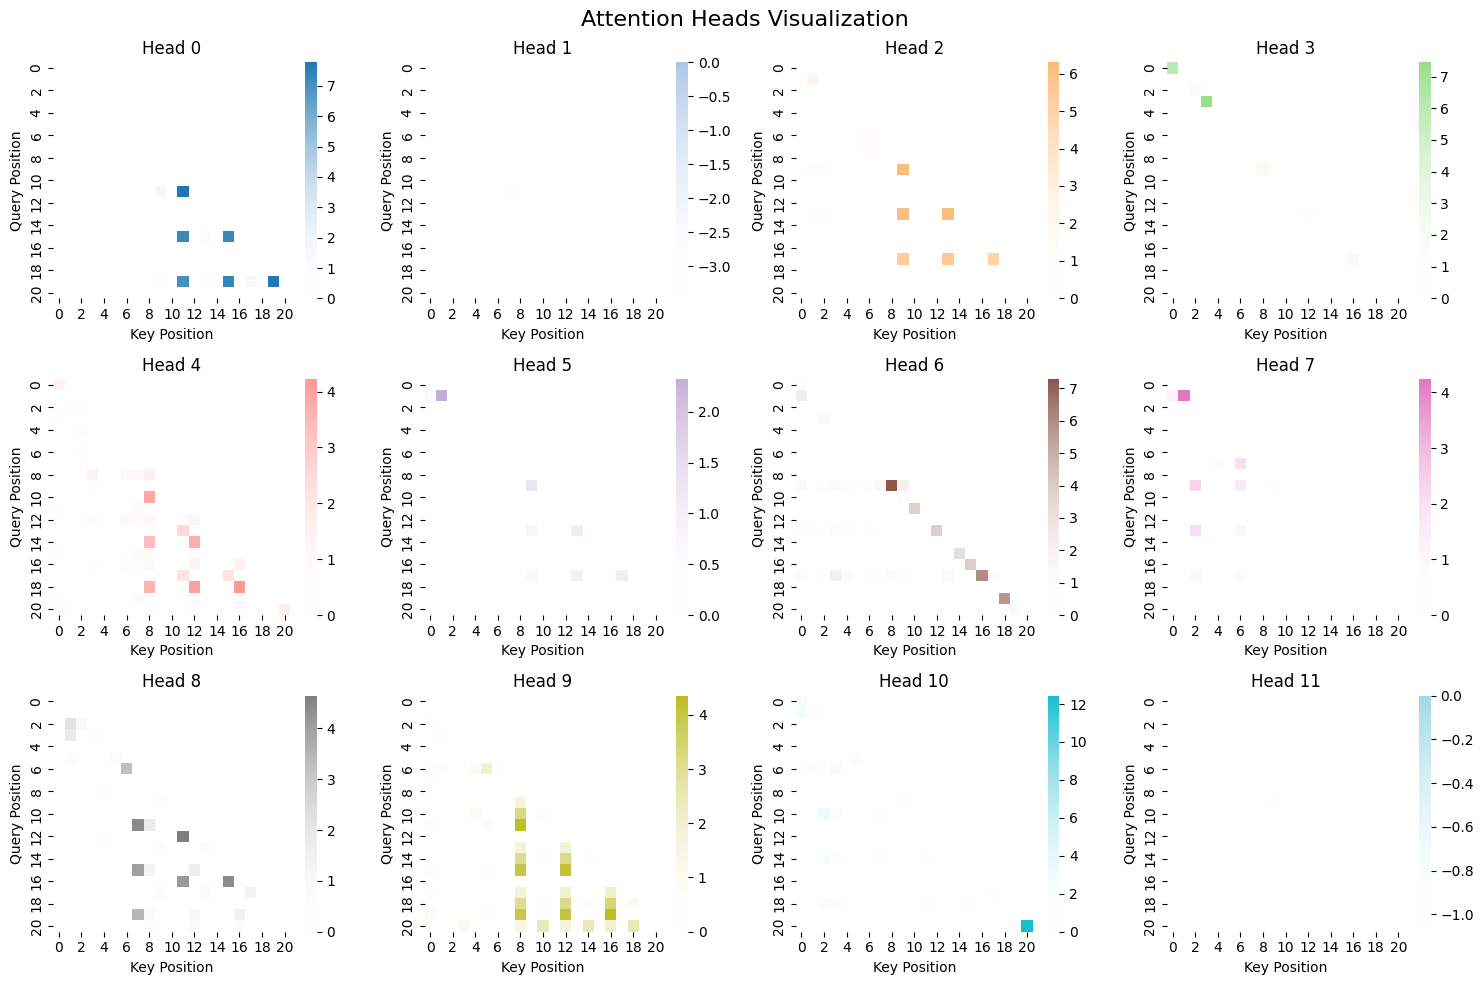

In [292]:
fig = plot_attention_heads(qk_scores)
plt.show()

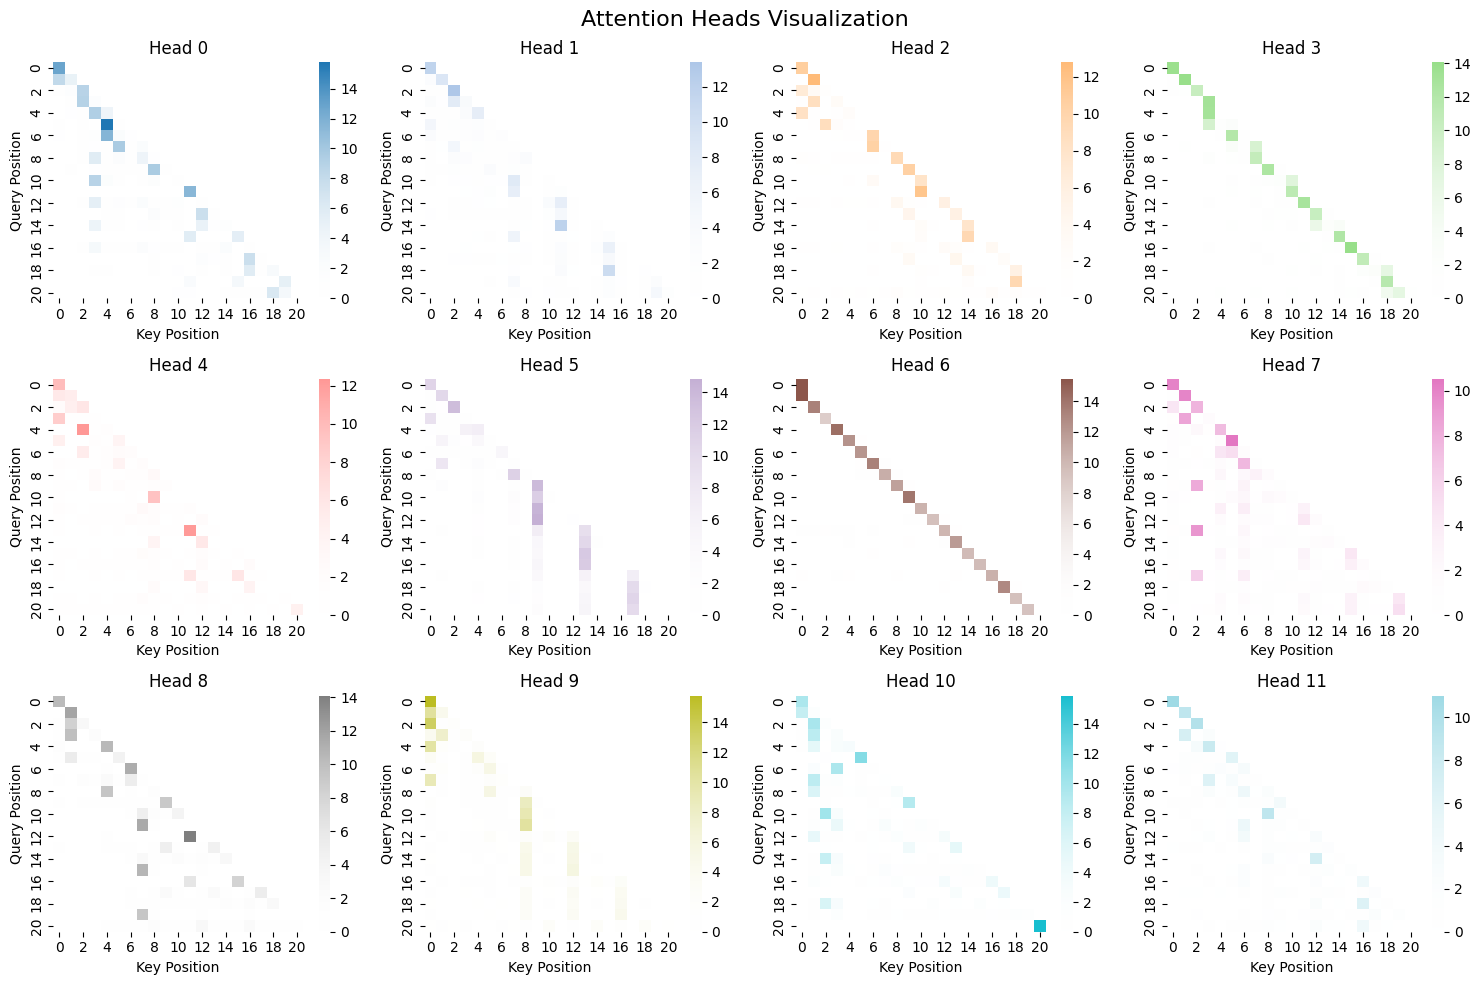

In [293]:
v_norms = torch.norm(v_output, p=2, dim=-1)
v_norms_expanded = v_norms.unsqueeze(-2)
weighted_contributions = attention_pattern * v_norms_expanded

fig = plot_attention_heads(weighted_contributions)
plt.show()

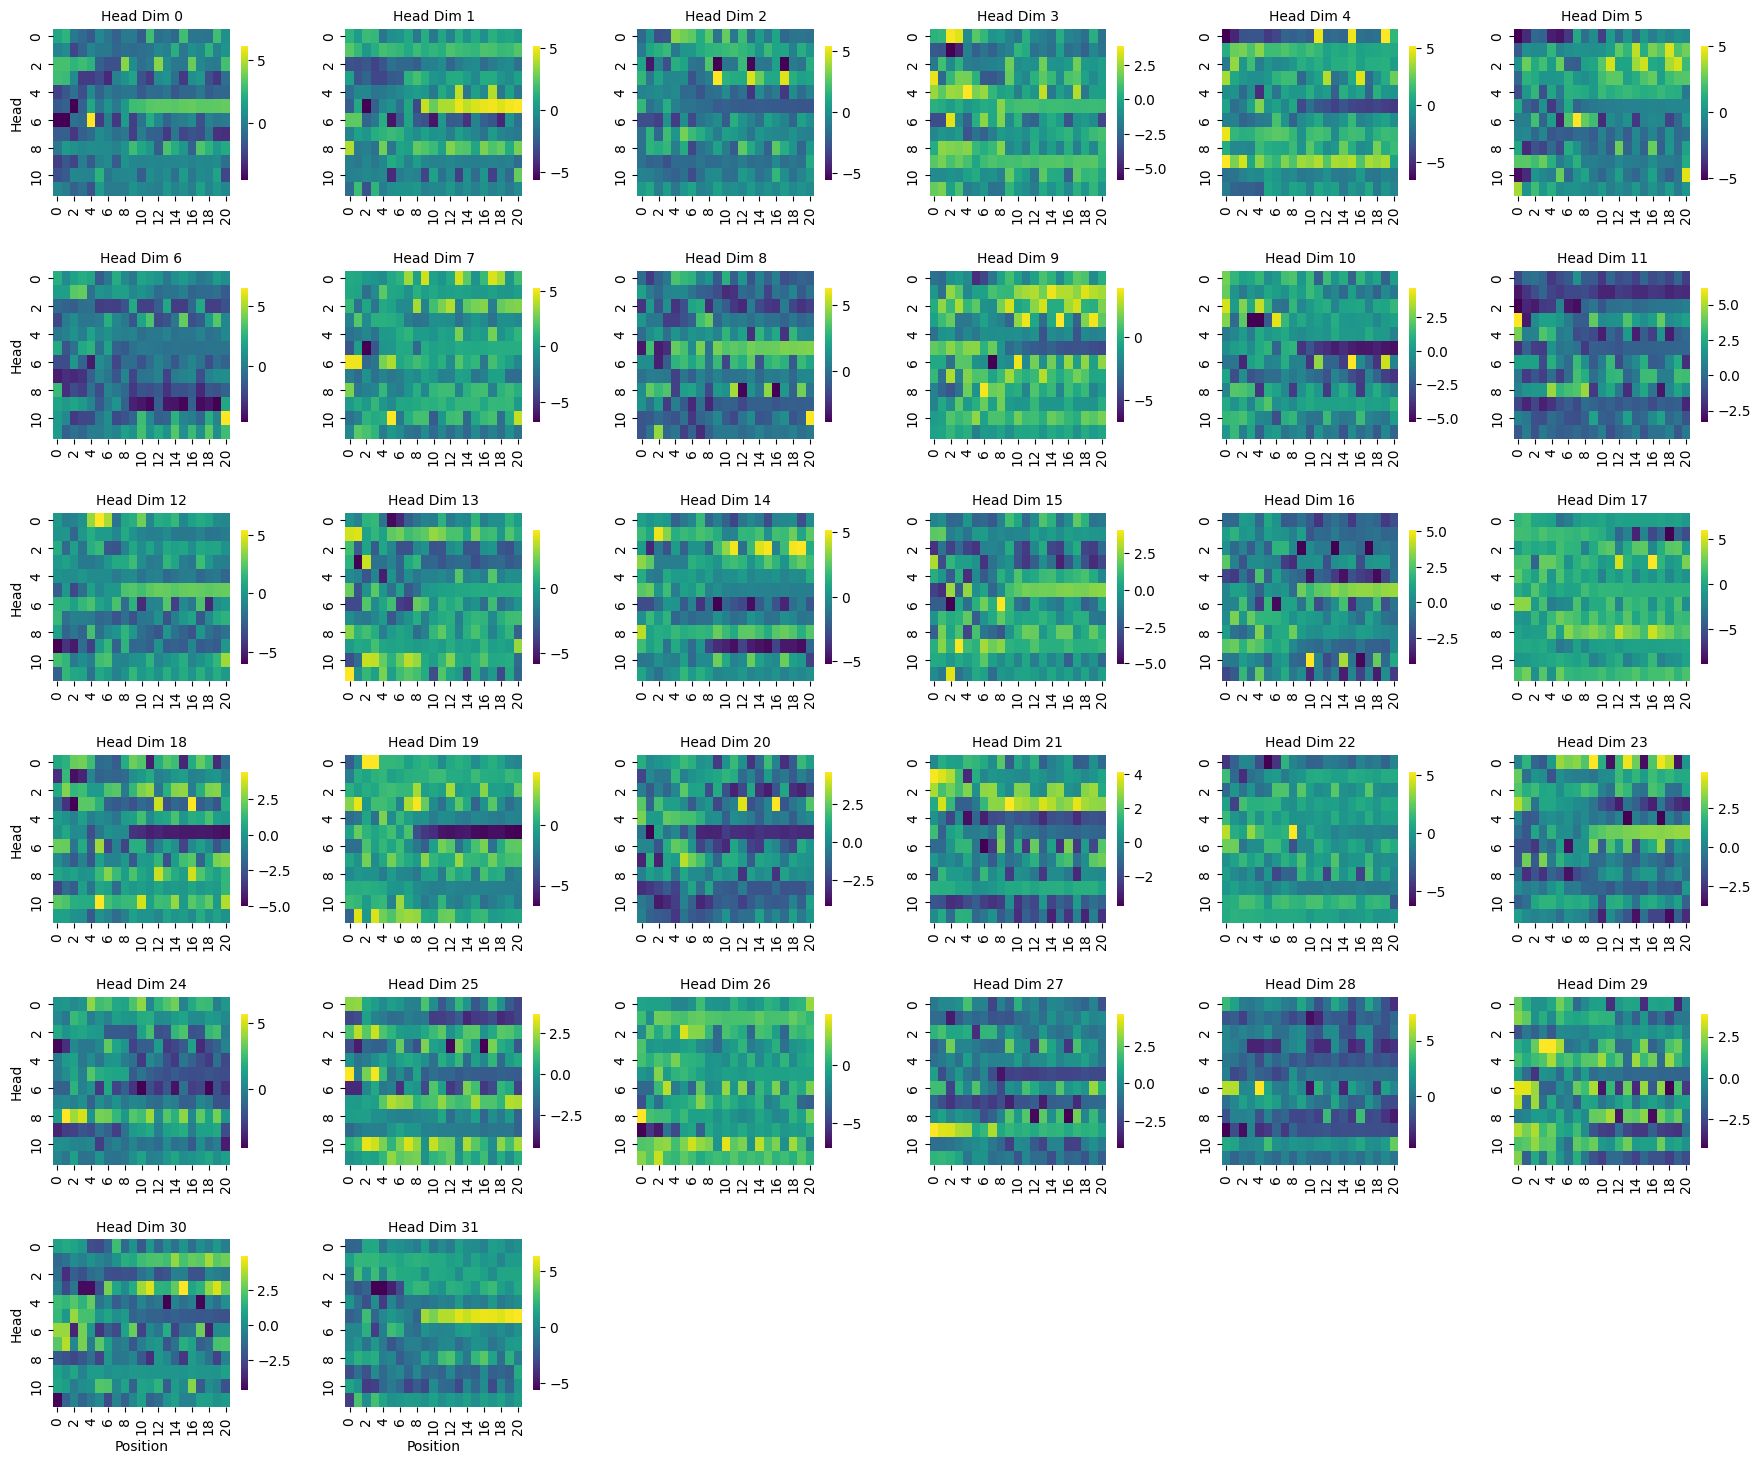

In [301]:
def visualize_attention_dimensions(z_output, n_heads, d_head, dimensions_to_show=None):
    # Reshape to [batch_size, seq_len, n_heads, d_head]
    reshaped = z_output.cpu().numpy().reshape(z_output.shape[0], z_output.shape[1], n_heads, d_head)

    # Default to showing all dimensions if not specified
    if dimensions_to_show is None:
        dimensions_to_show = list(range(d_head))

    n_dims_to_show = len(dimensions_to_show)
    if n_dims_to_show == 0:
        print("No dimensions to show.")
        return None

    # --- Key Change: Calculate grid size (rows, cols) ---
    n_cols = int(np.ceil(np.sqrt(n_dims_to_show)))
    n_rows = int(np.ceil(n_dims_to_show / n_cols))

    # --- Key Change: Create a grid of subplots ---
    # Adjust figure size dynamically based on the grid
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 2.5))

    # Flatten the 2D axes array into a 1D array for easy iteration
    # This handles cases where n_rows or n_cols is 1
    axes = axes.flatten() if n_dims_to_show > 1 else [axes]

    for i, dim in enumerate(dimensions_to_show):
        ax = axes[i]
        sns.heatmap(
            reshaped[0, :, :, dim].T,  # Transpose to have heads on y-axis
            ax=ax,
            cmap='viridis',
            cbar=True,
            cbar_kws={"shrink": 0.8} # Make colorbars a bit smaller
        )
        ax.set_title(f'Head Dim {dim}', fontsize=10)

        # --- Improvement: Place labels only on the edges for clarity ---
        # Set y-label (Head) only for the first column
        if i % n_cols == 0:
            ax.set_ylabel('Head')
        else:
            ax.set_ylabel('')
        
        # Set x-label (Position) only for the bottom row
        if i >= (n_rows - 1) * n_cols:
            ax.set_xlabel('Position')
        else:
            ax.set_xlabel('')

    # --- Key Change: Hide any unused subplots in the grid ---
    for i in range(n_dims_to_show, n_rows * n_cols):
        axes[i].axis('off')

    plt.tight_layout(pad=2.0) # Add padding to prevent title overlap
    return fig

fig_all = visualize_attention_dimensions(z_output, n_heads, d_head)
plt.show()

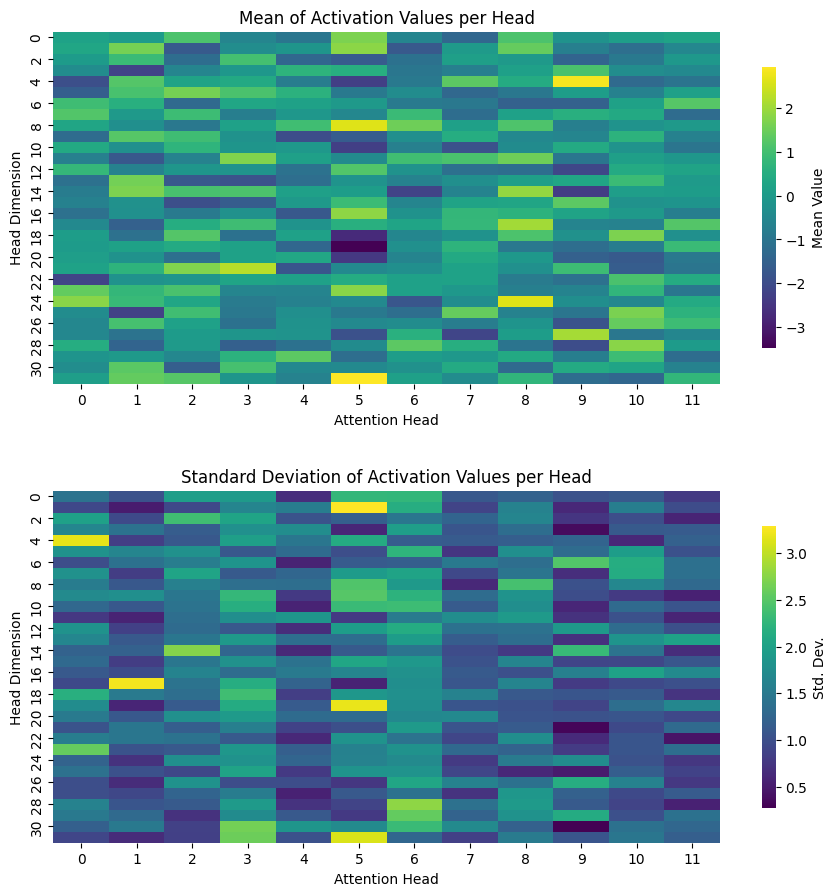

In [ ]:
def visualize_head_statistics(z_output, n_heads, d_head):
    # Reshape to [batch_size, seq_len, n_heads, d_head]
    reshaped = z_output.cpu().numpy().reshape(z_output.shape[0], z_output.shape[1], n_heads, d_head)
    
    mean_values = np.mean(reshaped[0], axis=0)
    std_values = np.std(reshaped[0], axis=0)
    
    fig_width = max(8, n_heads * 0.8)
    fig_height_per_plot = max(4, d_head * 0.15)
    fig, axes = plt.subplots(2, 1, figsize=(fig_width, fig_height_per_plot * 2))
    
    sns.heatmap(
        mean_values.T, 
        ax=axes[0], 
        cmap='viridis', 
        cbar_kws={"shrink": 0.8, "label": "Mean Value"}
    )
    axes[0].set_title('Mean of Activation Values per Head')
    axes[0].set_xlabel('Attention Head')
    axes[0].set_ylabel('Head Dimension')
    
    # Plot Standard Deviation
    sns.heatmap(
        std_values.T, 
        ax=axes[1], 
        cmap='viridis', 
        cbar_kws={"shrink": 0.8, "label": "Std. Dev."}
    )
    axes[1].set_title('Standard Deviation of Activation Values per Head')
    axes[1].set_xlabel('Attention Head')
    axes[1].set_ylabel('Head Dimension')
    
    plt.tight_layout(pad=3.0) # Add padding to prevent title/label overlap
    return fig

fig = visualize_head_statistics(z_output, n_heads, d_head)
plt.show()